# Increase Fairness in Your Driverless AI Experiment with `Compliant` Mode & Disparate Impact Analysis (DIA) using Pandas, Numpy, and Datatable

#### Assess if your Driverless AI experiment is treating different groups of people similarly or differently

Fairness in machine learning is a very important topic in many respects, but it is a highly complex entity. So much so that leading researchers in the field have yet to agree on a strict definition (there is no concrete "fairness metric"). However, there is a practical way to discuss and handle *observational* fairness or simply put, how your model predictions affect different groups. This procedure is known as disparate impact analysis (DIA). DIA is far from perfect, as it relies heavily on user-defined thresholds and reference levels for disparity and does not attempt to remediate disparity or provide information on sources of disparity, but it is a fairly straightforward method to quantify your model’s behavior across sensitive demographic segments or other potentially interesting groups of observations. DIA is also an accepted, regulation-compliant tool for fair-lending purposes in the U.S. financial services industry. 

This example DIA notebook starts by importing a dataset that contains the UCI credit card default data with predictions of defaulting and not defaulting from a Driverless AI model ran in [`Compliant`](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/expert-settings.html?highlight=compliant) mode. A probability cutoff for making credit decisions is selected by maximizing the `F1` statistic and confusion matrices are generated to summarize the DAI model’s decisions across customers with different gender levels. A basic DIA procedure is then conducted using the information stored in the confusion matrices. 

For an excellent and free reference on the topics of fairness and machine learning be sure to follow the book being written by Solon Barocas, Moritz Hardt and Arvind Narayanan: https://fairmlbook.org/. 

For Python fairness libraries that go far beyond the scope of this notebook see: 
* aequitas: https://github.com/dssg/aequitas
* AI Fairness 360: http://aif360.mybluemix.net/
* Themis: https://github.com/LASER-UMASS/Themis

#### Python imports 

In [2]:
import numpy as np   
import pandas as pd 
import datatable as dt
from datatable import f

%matplotlib inline   

## 1. Import, explore, and prepare UCI credit card default data with predictions from a DAI experiment ran in `Compliant` mode

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

#### Import data and clean

In [3]:
# import
path = '../data/compliance_maralutu.csv'
data = dt.fread(path).to_pandas()

# remove spaces from the target column, probabilty of not defaulting column, and the probability of defaulting column
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 
data = data.rename(columns={'default payment next month.0': 'p_DEFAULT_NEXT_MONTH_0'}) 
data = data.rename(columns={'default payment next month.1': 'p_DEFAULT_NEXT_MONTH_1'}) 

In [4]:
# See first 5 rows of dataset
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH_0,p_DEFAULT_NEXT_MONTH_1
0,24001,50000,1,2,2,23,2,2,0,0,...,20066,8,2401,2254,2004,704,707,0,0.475958,0.524042
1,24002,60000,1,2,2,26,0,0,0,0,...,28847,2282,2324,2049,2000,3000,1120,1,0.751394,0.248606
2,24003,400000,1,2,2,27,0,0,0,0,...,9545,2501,10009,1437,1105,510,959,0,0.744261,0.255739
3,24004,20000,1,5,2,27,5,4,3,2,...,19840,0,0,0,900,0,0,0,0.107301,0.892699
4,24005,50000,1,3,2,27,0,0,-2,-2,...,120,0,100,0,70,200,100,0,0.779270,0.220730


#### Helper function for recoding values in the UCI credict card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset.

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        Pandas with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return frame

data = recode_cc_data(data)

#### Display descriptive statistics
The `describe()` function displays a brief description of the credit card default data. For the categorical input variables `LIMIT_BAL`, `SEX`, `EDUCATION`, `MARRIAGE`, and `PAY_0`-`PAY_6`, the new character values created above in cell 5 are visible. Basic descriptive statistics are displayed for numeric inputs.

In [6]:
data.describe()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH_0,p_DEFAULT_NEXT_MONTH_1
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03
mean,27000.500000,175437.666667,35.905667,53729.115667,51311.119333,49597.543500,46841.991167,41554.274667,40103.959500,6146.250833,6.344473e+03,6251.343500,5156.464167,4862.994000,5319.916667,0.211000,0.758643,2.413574e-01
std,1732.195139,131905.841315,8.990675,77411.882245,74290.225276,73739.999695,69041.251707,62562.774782,61111.043232,21523.044734,3.040158e+04,22638.732479,18466.518562,15310.976004,18355.191015,0.408052,0.136373,1.363728e-01
min,24001.000000,10000.000000,21.000000,-11545.000000,-67526.000000,-46127.000000,-65167.000000,-61372.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.028743,2.250000e-10
25%,25500.750000,60000.000000,29.000000,3213.000000,2578.500000,2487.750000,2290.750000,1900.000000,1320.000000,1000.000000,9.900000e+02,799.750000,326.000000,278.750000,288.750000,0.000000,0.734587,1.521857e-01
50%,27000.500000,150000.000000,34.000000,22820.000000,20814.500000,20360.500000,19657.000000,18071.500000,17203.500000,2195.500000,2.230000e+03,2000.000000,1634.500000,1590.000000,1697.000000,0.000000,0.768536,2.314636e-01
75%,28500.250000,250000.000000,42.000000,71456.500000,68612.250000,65252.750000,61357.750000,52099.000000,50620.500000,5188.750000,5.042250e+03,5000.000000,4209.500000,4145.000000,4300.000000,0.000000,0.847814,2.654130e-01
max,30000.000000,780000.000000,75.000000,746814.000000,671563.000000,855086.000000,706864.000000,587067.000000,514975.000000,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,443001.000000,1.000000,1.000000,9.712565e-01


# 3. Select a Probability Cutoff by Maximizing F1 Statistic

#### Function to calculate AUC-PR Curve

Classification models often produce probabilities, not decisions. So to make a decision with a model-generated predicted probability for any one customer, you must specify a numeric cutoff above which we say a customer will default and below which we say they will not default. Cutoffs play a crucial role in DIA as they impact the underlying measurements used to calculate diparity. In fact, tuning cutoffs carefully is a potential remdiation tactic for any discovered disparity. There are many accepted ways to select a cutoff (besides simply using 0.5) and in this notebook the cutoff will be selected by striking a balance between the model's recall (true positive rate) and it's precision using the F1 statistic.  

To learn more about confusion matrices see: https://en.wikipedia.org/wiki/Confusion_matrix.

#### Create datatable version of test_yhat

In [7]:
data_dt = dt.Frame(data)
data_dt.head(n=5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,…,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH_0,p_DEFAULT_NEXT_MONTH_1
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,…,▪▪▪▪,▪▪▪▪,▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪
0,24001,50000,male,university,single,23,2 month delay,2 month delay,use of revolving credit,use of revolving credit,…,704,707,0,0.475958,0.524042
1,24002,60000,male,university,single,26,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,…,3000,1120,1,0.751394,0.248606
2,24003,400000,male,university,single,27,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,…,510,959,0,0.744261,0.255739
3,24004,20000,male,other,single,27,5 month delay,4 month delay,3 month delay,2 month delay,…,0,0,0,0.107301,0.892699
4,24005,50000,male,high school,single,27,use of revolving credit,use of revolving credit,no consumption,no consumption,…,200,100,0,0.77927,0.22073


In [8]:
def get_prroc_dt(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a datatable of y and yhat values.
    
    Args:
        frame: Datatable of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Datatable of precision, recall, and f1 values. 
    """
    
    frame_ = frame # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prroc_frame = dt.Frame({"cutoff" : [], "recall" : [], "precision" : [], "f1" : []})
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values                      
        frame_[:, dname] = 0; 
        frame_[f[yhat] > cutoff, dname] = 1

        # calculate confusion matrix values
        tp = frame_[(f[dname] == pos) & (f[y] == pos), :].shape[0]
        fp = frame_[(f[dname] == pos) & (f[y] == neg), :].shape[0]
        tn = frame_[(f[dname] == neg) & (f[y] == neg), :].shape[0]
        fn = frame_[(f[dname] == neg) & (f[y] == pos), :].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prroc_frame.rbind(dt.Frame({'cutoff': [cutoff], 
                                                 'recall': [recall],
                                                 'precision': [precision],
                                                 'f1': [f1]}))
    
    return prroc_frame
        
prroc_frame = get_prroc_dt(data_dt, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH_1')

#### Select best cutoff by using get_prroc()

In [9]:
from datatable import max
best_cut = prroc_frame[f.f1 == max(f.f1),:][:,f.cutoff][0,0]
print('%.2f' % best_cut)

0.29


#### Plot AUC-PR Curve

An area under the curve for precision and recall (AUC-PR) plot is a typical way to visualize recall and precision for a predictive model. The F1 statistic is the harmonic mean of recall and precision, and we can visualize where F1 is maximized on with the AUC-PR curve.

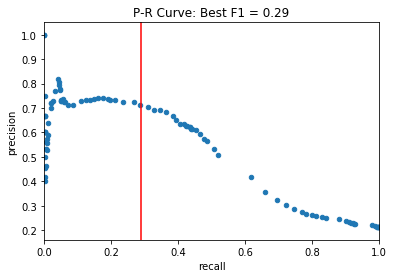

In [10]:
# Plot P-R ROC w/ best cutoff
title_ = 'P-R Curve: Best F1 = ' + str(best_cut)
ax = prroc_frame.to_pandas().plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

# 4. Report Raw Confusion Matrices

The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the DAI model's behavior in general and across eduction levels.

#### Functions to print confusion matrices by an input variable

In [11]:
def get_confusion_matrix_dt(frame, y, yhat, by=None, level=None, cutoff=0.5, convert_to_pandas=False):
    """ Creates confusion matrix from a datatable of y and yhat values, can be sliced 
    by a variable and level.
    
    Args:
        frame: Datatable of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as datatable 
    """
    level_list = dt.unique(frame[:,y]).to_list()[0]
    level_list.sort(reverse=True)
    cm_frame = dt.Frame({"actual" + str(level_list[0]) : [np.nan], "actual" + str(level_list[1]) : [np.nan]})
    cm_frame.rbind(cm_frame)
    
    # Do not destroy original data
    frame_ = frame

    dname = 'd_' + str(y)
    frame_[:, dname] = 0; 
    frame_[f[yhat] > cutoff, dname] = 1

    if (by is not None) & (level is not None):
        frame_ = frame_[f[by] == level,:]
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame[i, j] = frame_[(f[y] == lev_i) & (f[dname] == lev_j), :].shape[0]
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    if convert_to_pandas:
        cm_frame = cm_frame.to_pandas()
        cm_frame.columns = ["actual: " + str(i) for i in level_list]
        cm_frame.index = ["predicted: " + str(i) for i in level_list]
    
    return cm_frame

get_confusion_matrix_dt(data_dt, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH_1', cutoff=best_cut, convert_to_pandas=True)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,617.0,649.0
predicted: 0,479.0,4255.0


The general confusion matrix shows that the DAI model is more accurate than not because the true positive and true negative cells contain the largest values by far. But the DAI model seems to make a large number of type I errors or false positive predictions. False positives are a known disparity issue, because for complex reasons, many credit scoring and other models tend to overestimate the likelihood a reference group to default. This is both a sociological fairness problem and a financial problem if a group is not getting loans they really deserve.

#### Report confusion matrices by SEX

Because race is unavailable in the UCI credit card data set, `SEX` level will be used to perform DIA.

In [12]:
sex_levels = dt.unique(data_dt[:,'SEX']).to_list()[0]
sex_levels

['female', 'male']

#### Confusion matrix for `SEX = male`

In [13]:
male_cm_dt = get_confusion_matrix_dt(data_dt, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH_1', by='SEX', level='male', 
                                     cutoff=best_cut, convert_to_pandas=True)
male_cm_dt

Confusion matrix by SEX=male


,actual: 1,actual: 0
predicted: 1,334.0,352.0
predicted: 0,247.0,2033.0


#### Confusion matrix for `SEX = female`

In [14]:
female_cm_dt = get_confusion_matrix_dt(data_dt, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH_1', by='SEX', level='female', 
                                       cutoff=best_cut, convert_to_pandas=True)
female_cm_dt

Confusion matrix by SEX=female


,actual: 1,actual: 0
predicted: 1,283.0,297.0
predicted: 0,232.0,2222.0


# 5. Disparate Impact Analysis (DIA)

To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the DAI models overall performance and how it behaves when predicting:

* Default correctly
* Non-default correctly
* Default incorrectly (type I errors)
* Non-default incorrectly (type II errors)

In a real-life lending scenario, type I errors essentially amount to false accusations of financial impropriety and type II errors result in awarding loans to undeserving customers. Both types of errors can be costly to the lender too. Type I errors likely result in lost interest and fees. Type II errors often result in write-offs.

#### Dictionary of metrics used to assess parity

In [15]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
#'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group 
'Accuracy':   '(tp + tn) / (tp + tn +fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

#### Utility function to translate metrics into Pandas statements

In [16]:
# small utility function
# translates abbreviated metric expressions into executable Python statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level][0, 0]')\
                           .replace('fp', 'cm_dict[level][0, 1]')\
                           .replace('fn', 'cm_dict[level][1, 0]')\
                           .replace('tn', 'cm_dict[level][1, 1]')

    return expression


#### Calculate and report metrics
This nested loop calculates all the metrics defined above for each gender level.

In [17]:
# initialize dict of confusion matrices and corresponding rows of dataframe
cm_dict = {'male': dt.Frame(male_cm_dt), 
           'female': dt.Frame(female_cm_dt)} 

metrics = dt.Frame(names=list(metric_dict.keys()), stypes = [dt.stype.float32] * len(list(metric_dict.keys())))
metrics.nrows=len(sex_levels)
groups = dt.Frame(Groups=sex_levels)
# nested loop through:
# - gender levels
# - metrics 
for i, level in enumerate(sex_levels):
    for j, metric in enumerate(metric_dict.keys()):
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])
        # dynamically evaluate metrics to avoid code duplication
        metrics[i, j] = eval(expression)

# display results                
metrics_frame = dt.cbind(groups, metrics)
metrics_frame.head()

,Groups,Adverse Impact,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,female,0.191167,0.825643,0.549515,0.487931,0.882096,0.90546,0.117904,0.512069,0.450485,0.0945395
1,male,0.231288,0.798045,0.574871,0.48688,0.852411,0.891667,0.147589,0.51312,0.425129,0.108333


From eyeballing the raw metrics we can start to see very few disparity problems except for `False Positive Rate` and `Specificity`. However, these do not show a big difference between gender groups.

#### Plot false negative rate by sex level 

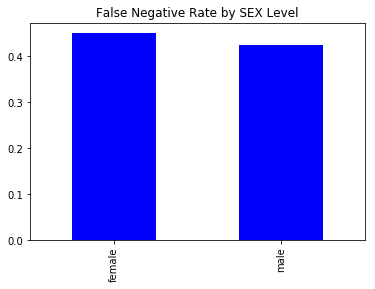

In [18]:
# Convert datatable to Pandas for plotting
metrics_frame_pandas = metrics_frame.to_pandas()
metrics_frame_pandas.index = metrics_frame_pandas["Groups"].values
metrics_frame_pandas.drop("Groups", axis=1, inplace=True)
_ = metrics_frame_pandas['False Negative Rate'].plot(kind='bar', color='b', title='False Negative Rate by SEX Level')

#### Plot false positive rate by sex level 

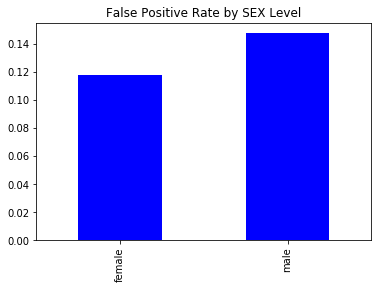

In [19]:
__ = metrics_frame_pandas['False Positive Rate'].plot(kind='bar', color='b', title='False Positive Rate by SEX Level')

#### Calculate and report disparity
To calculate disparity we compare the confusion matrix for each sex level to the metrics for a user-defined reference level and to user-defined thresholds. In this case, we take the class of people who seem least likely to default as the reference level, i.e. `SEX = male`.We set thresholds such that metrics 20% lower or higher than the reference level metric will be flagged as disparate. 

In [20]:
ref_level = 'male' # user-defined reference level

parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value

ref_group = metrics_frame[f.Groups == ref_level,:]
ref_group = ref_group[:,list(metric_dict.keys())]

disp_col_names = columns=[col + '_Disparity' for col in list(metric_dict.keys())]
disp_frame = metrics_frame[:,list(metric_dict.keys())]

for disparity_measure in disp_col_names:
    measure = disparity_measure.rsplit('_', 1)[0]
    ref_group[:,f[measure]][0,0]
    disp_frame[:,disparity_measure] = disp_frame[:,f[measure]/ref_group[:,f[measure]][0,0]]
disp_frame

# small utility function to format pandas table output
def disparate_red(val):
   
   color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
   return 'color: %s' % color 

disp_frame = disp_frame[:,disp_col_names]
disp_frame_pd = disp_frame.to_pandas()
disp_frame_pd.index =sex_levels
disp_frame_pd.head()
# display results
disp_frame_pd.style.applymap(disparate_red)

,Adverse Impact_Disparity,Accuracy_Disparity,True Positive Rate_Disparity,Precision_Disparity,Specificity_Disparity,Negative Predicted Value_Disparity,False Positive Rate_Disparity,False Discovery Rate_Disparity,False Negative Rate_Disparity,False Omissions Rate_Disparity
female,0.826532,1.03458,0.955892,1.00216,1.03482,1.01547,0.798866,0.997953,1.05964,0.872673
male,1,1,1,1,1,1,1,1,1,1


For the selected thresholds, the DAI model appears to have only one disparate value for `False Positive Rate`. However, the disparity is quite small.

#### Plot false positive rate disparity

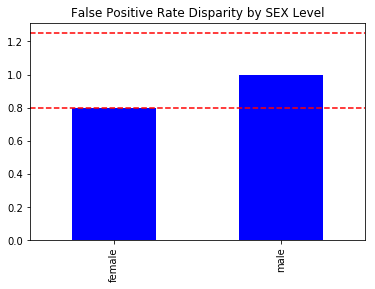

In [28]:
ax = disp_frame_pd['False Positive Rate_Disparity'].plot(kind='bar', color='b', title='False Positive Rate Disparity by SEX Level')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

#### Plot false negative rate disparity

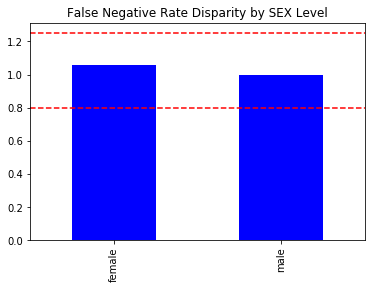

In [29]:
ax = disp_frame_pd['False Negative Rate_Disparity'].plot(kind='bar', color='b', title='False Negative Rate Disparity by SEX Level')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

#### Assess and report parity
A binary indication of parity for metrics is reported by simply checking whether disparity values are within the user-defined thresholds. Further parity indicators are defined as combinations of other disparity values:

* Type I Parity: Fairness in both FDR Parity and FPR Parity
* Type II Parity: Fairness in both FOR Parity and FNR Parity
* Equalized Odds: Fairness in both FPR Parity and TPR Parity
* Supervised Fairness: Fairness in both Type I and Type II Parity
* Overall Fairness: Fairness across all parities for all metrics

In [23]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_col_names = columns=[col + ' Parity' for col in list(metric_dict.keys())]
par_frame = dt.Frame(names=par_col_names, stypes = [dt.stype.bool8] * len(par_col_names))
par_levels = sex_levels
par_frame.nrows = len(par_levels)

# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(sex_levels):
    for j, _ in enumerate(par_frame.names):
        # frame_[(f[y] == lev_i) & (f[dname] == lev_j), :].shape[0]
        if parity_threshold_low < disp_frame[i,j] < parity_threshold_hi:
            par_frame[i, j] = True
        else:
            par_frame[i, j] = False


# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all metrics
par_frame[:,'Type I Parity'] = par_frame[:,f['False Discovery Rate Parity'] & f['False Positive Rate Parity']]
par_frame[:,'Type II Parity'] = par_frame[:,f['False Omissions Rate Parity'] & f['False Negative Rate Parity']]
par_frame[:,'Equalized Odds'] = par_frame[:,f['False Positive Rate Parity'] & f['True Positive Rate Parity']]
par_frame[:,'Supervised Fairness'] = par_frame[:,f['Type I Parity'] & f['Type II Parity']]
par_frame[:, 'Overall Fairness'] = par_frame[:,f['Type I Parity'] & f['Type II Parity'] & 
                                             f['False Positive Rate Parity'] & f['True Positive Rate Parity'] &
                                             f['False Omissions Rate Parity'] & f['False Negative Rate Parity'] &
                                             f['False Discovery Rate Parity'] & f['False Positive Rate Parity']]

par_frame_groups = dt.Frame(Groups = par_levels)
par_frame_groups.nrows = len(par_levels)
par_frame = dt.cbind(par_frame_groups, par_frame)

par_frame_all = dt.cbind(dt.Frame(dt.Frame(par_frame.sum())))
par_frame_all[0,"Groups"] = 'all'
par_frame_all_metrics = list(par_frame.names)
par_frame_all_metrics.remove("Groups")
par_frame_all_metrics

for j in range(1,len(par_frame_all_metrics) + 1):
    if par_frame_all[0, j] == len(par_levels):
        par_frame_all[0, j] = True
    else:
        par_frame_all[0, j] = False 

par_frame = dt.rbind(par_frame, par_frame_all)
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 

par_frame = par_frame
par_frame_pd = par_frame.to_pandas()
par_frame_pd = par_frame_pd.drop(["Groups"], axis=1)
par_frame_pd.index = par_levels + ["all"]
# display results
par_frame_pd.style.applymap(color_false_red)

,Adverse Impact Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
female,1,1,1,1,1,1,0,1,1,1,0,1,0,0,0
male,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
all,1,1,1,1,1,1,0,1,1,1,0,1,0,0,0


In general the DAI model appears to have accuracy, negative predicted value, and specificity parity, but has disparate impact across sex levels for `False Positive Rate Parity`, `Type 1 Parity`, `Equalized Odds`, `Supervised Fairness`, and `Overall Fairness`. To address such disparate impact users could tune the DAI model cutoff or regularization, could try new methods for reweighing data prior to model training or try new modeling methods specifically designed for fairness. Simply dropping the variable `SEX` is likely an inappropriate solution. In nonlinear models, different variables are combined by the model to represent strong signals. If a variable is important in a dataset, model, or problem domain it's likely that a nonlinear model will find combinations of other variables to act as proxies for the problematic variable -- potentially even different combinations for different rows of data!. So by simply dropping the variable from the model, you will likely not solve the disparate impact problem, but instead just make it harder to diagnose.

#### Conclusion

This notebook outlines a basic approach to DIA. In a complex, real-world machine learning project the hard-to-define phenomenas of sociological bias and unfairness can materialize in many ways and from many different sources. Although far from a flawless technique, the beauty of DIA is it is straightforward to implement, functions in a model-agnostic fashion on known labels and model predictions, and is applied in complex real-world fair lending situations, so it can probably be applied to your model too!

Why risk being called out in the media for training an unfair model? Or why not investigate the monetary opportunity costs of type I errors and potential losses from type II errors? Why not do the right thing and investigate how your model treats people?